# Carbon Assessment of Business Travels (Data Correction)

In [1]:
import pathlib
import pandas as pd
import geopandas as gpd
from geopy.distance import geodesic
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import graphviz
%matplotlib inline

In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn import tree
from sklearn.naive_bayes import GaussianNB#, CategoricalNB

In [3]:
import warnings
warnings.simplefilter("ignore")

## Forewords

### Disclaimer

 > Data insights provided in this notebook are not validated and may certainly contain errors. They are shared for feedback only with no warranty or liability of any kind.

### Credits

Please refer (citation) to this preliminary report as follow:

 > Report [not validated]: *Carbon Assessment of Business Travels (Data Insights)*, Jean Landercy (SmartCampus), 2020-03-20

Additionally, also cite sources listed below.

### History

 - 2020-03-18: Started to explore Missions Dataset provided by ULB/DTAS/BEP;
 - 2020-03-20: First version of this report submitted to review;

### Sources

 - ULB/Faculty, Faculty mission: anonymized administrative forms (CSV);
 - ULB/DTAS/BEP, Travel Types Carbon Coefficient (Excel);
 - ArgGIS Hub, Country of the World (GeoJSON);
 - OSM, Nominatim Geocoding API (JSON);
 - OSM, Map Web Interface;
  

## Load datasets

In [4]:
travels = pd.read_excel('data/travels.xlsx')

In [5]:
travels.columns

Index(['travel_id', 'mission_id', 'from_geocodeid', 'from_citycleansed',
       'from_ISO2', 'from_city', 'from_lat', 'from_lon', 'from_accuracy',
       'from_confidence', 'to_geocodeid', 'to_citycleansed', 'to_ISO2',
       'to_city', 'to_lat', 'to_lon', 'to_accuracy', 'to_confidence', 'start',
       'stop', 'travel_type', 'acronym', 'faculty', 'elapsed', 'distance'],
      dtype='object')

### Tortuosity assessment

In order to convert distance as crow flies into meaningful distance for car, we need to model it. Our base hypothesis is: tortuosity (crookness) depends on travel type and distance. We will model car tortuosity by regression of geodesic distance with car travel distance estimated with OSM Web Interface.

We collected about 80 observations of car travel distances:

In [6]:
crook = pd.read_excel("data/crookness.xlsx").rename(columns={'mean': 'direct'})
crook = crook.dropna().drop(['from_city', 'to_city'], axis=1)
crook.describe()

,from_geocodeid,to_geocodeid,count,direct,car
count,78.000000,78.000000,78.000000,78.000000,78.000000
mean,97.076923,106.871795,41.205128,695.414237,876.987179
std,186.529951,150.657378,124.606222,636.891454,812.292435
min,0.000000,0.000000,9.000000,23.826959,30.000000
25%,0.000000,0.000000,11.250000,275.267010,336.750000
50%,0.000000,28.500000,19.000000,564.992816,692.500000
75%,132.500000,161.750000,34.750000,869.595384,1106.500000
max,940.000000,617.000000,1107.000000,4463.378835,5483.000000


In [7]:
crook[['direct', 'car']].corr()

,direct,car
direct,1.000000,0.991366
car,0.991366,1.000000


Figure below confirms correlation is linear and table above shows a quite good correlation coefficient:

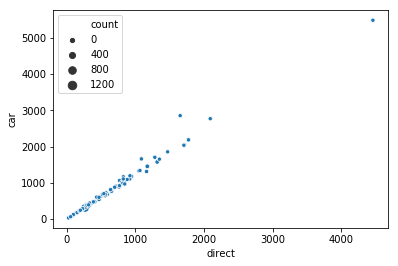

In [8]:
sns.scatterplot(x='direct', y='car', size='count', data=crook)

We try two robust regressors (Siegel & Theils) to compare with classic OLS:

In [9]:
res1 = stats.siegelslopes(crook['car'], crook['direct'])
res1

(1.239717205940134, -1.0586705457182575)

In [10]:
res2 = stats.theilslopes(crook['car'], crook['direct'], 0.90)
res2

(1.2387656869308534,
 -7.393713902781542,
 1.2229061684801663,
 1.2575257912879727)

In [11]:
res3 = stats.linregress(crook['direct'], crook['car'])
res3

LinregressResult(slope=1.2643897850797623, intercept=-2.2874781286162715, rvalue=0.9913659345237047, pvalue=8.085315897856664e-69, stderr=0.019183303443075568)

Car tortuosity is about 1.24 which seems a reasonable value, to keep the model as simple as possible we will ignore offset and avoid negative distance for small distances.

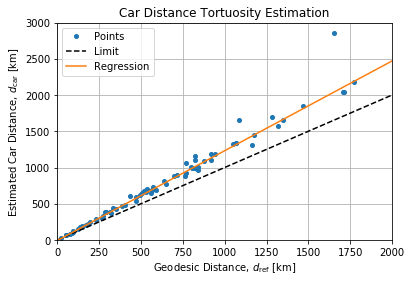

In [12]:
fig, axe = plt.subplots()
x = np.array([0, 2000])
axe.plot(crook['direct'], crook['car'], 'o', markersize=4, label='Points')
axe.plot(x, x, '--', color='k', label='Limit')
axe.plot(x, res2[1] + res2[0]*x, '-', label='Regression')
axe.set_xlim(x)
axe.set_ylim([0, 3000])
axe.set_title("Car Distance Tortuosity Estimation")
axe.set_xlabel(r"Geodesic Distance, $d_\mathrm{ref}$ [$\mathrm{km}$]")
axe.set_ylabel(r"Estimated Car Distance, $d_\mathrm{car}$ [$\mathrm{km}$]")
axe.legend()
axe.grid()

### Travel Type Classifier

We have two problem to address about travel_type:

 - Travel type are missing before 2018 (probably not collected);
 - Travel type are prone to error, there are outliers (misattributed or mixed travel type).
 
This makes travel type a good candidate for semi-supervised learning.

#### Data Conditioning

First we aggregated travels to missions to have metrics.

In [13]:
missions = travels.groupby('mission_id').agg({
    'acronym': 'first', 'faculty': 'first',
    'start': 'first', 'stop':'first', 'elapsed': 'first', 'travel_type': 'first',
    'from_ISO2': 'first', 'to_ISO2': list, 'distance': 'sum',
}).reset_index()
missions['speed'] = missions['distance']/(24*missions['elapsed'])
missions['steps'] = missions['to_ISO2'].apply(lambda x: len(x))
missions['step_distance'] = missions['distance']/missions['steps']
missions['ISO2_chain'] = missions.apply(lambda x: [x['from_ISO2']] + x['to_ISO2'], axis=1)
missions['to_ISO2'] = missions['to_ISO2'].apply(lambda x: x[0])
tttrans = {
    'plane/short': 'plane',
    'plane/eco': 'plane',
    'car/gas': 'car',
    'car/diesel': 'car',
    'bus': 'car',
    'plane/first': 'plane'
}
missions['travel_code'] = pd.Categorical(missions['travel_type'].replace(tttrans))
missions['acronym'] = pd.Categorical(missions['acronym'])
missions['faculty'] = pd.Categorical(missions['faculty'])
missions = missions.dropna(subset=['from_ISO2', 'to_ISO2'])
missions

,mission_id,acronym,faculty,start,stop,elapsed,travel_type,from_ISO2,to_ISO2,distance,speed,steps,step_distance,ISO2_chain,travel_code
0,0,DECA,LTC,2010-05-28,2010-06-01,5,NaN,BE,GB,810.745964,6.756216,3,270.248655,"[BE, GB, GB, BE]",NaN
1,1,SIC,LTC,2010-06-22,2010-07-08,17,NaN,BE,GB,645.698894,1.582595,2,322.849447,"[BE, GB, BE]",NaN
2,2,SIC,LTC,2010-06-22,2010-07-08,17,NaN,BE,GB,645.698894,1.582595,2,322.849447,"[BE, GB, BE]",NaN
3,3,SIC,LTC,2010-07-12,2010-07-17,6,NaN,BE,GB,645.698894,4.484020,2,322.849447,"[BE, GB, BE]",NaN
4,4,SIC,LTC,2010-05-31,2010-06-01,2,NaN,BE,FR,528.587028,11.012230,2,264.293514,"[BE, FR, BE]",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6125,6125,DECS,SBS,2020-02-20,2020-02-20,1,train,BE,GB,645.698894,26.904121,2,322.849447,"[BE, GB, BE]",train
6126,6126,DECS,SBS,2020-02-23,2020-02-28,6,train,BE,FR,1923.612609,13.358421,4,480.903152,"[BE, FR, FR, FR, BE]",train
6127,6127,L&L,LTC,2020-02-16,2020-02-18,3,train,BE,FR,1536.399657,21.338884,2,768.199829,"[BE, FR, BE]",train
6128,6128,DECS,SBS,2020-03-02,2020-03-03,2,train,NL,FR,860.923418,17.935905,2,430.461709,"[NL, FR, NL]",train


In [14]:
missions.dtypes

mission_id                int64
acronym                category
faculty                category
start            datetime64[ns]
stop             datetime64[ns]
elapsed                   int64
travel_type              object
from_ISO2                object
to_ISO2                  object
distance                float64
speed                   float64
steps                     int64
step_distance           float64
ISO2_chain               object
travel_code            category
dtype: object

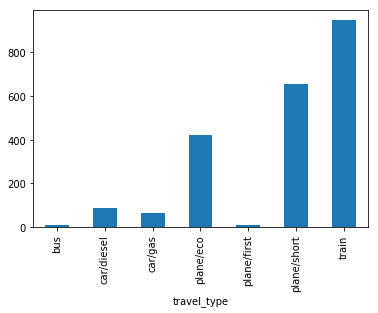

In [15]:
missions.groupby('travel_type')['mission_id'].count().plot(kind='bar')

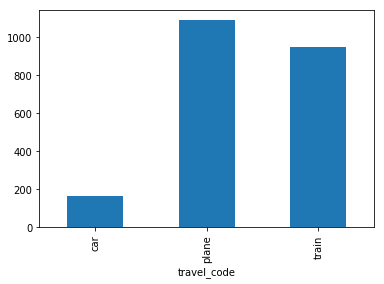

In [16]:
missions.groupby('travel_code')['mission_id'].count().plot(kind='bar')

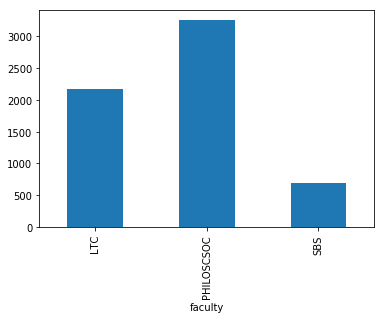

In [17]:
missions.groupby('faculty')['mission_id'].count().plot(kind='bar')

#### Outliers management

In [18]:
skeys = ['faculty', 'from_ISO2', 'to_ISO2', 'elapsed', 'steps', 'distance', 'step_distance', 'speed', 'travel_code']
subset  = missions.loc[~missions['travel_type'].isnull(),skeys]
subset

,faculty,from_ISO2,to_ISO2,elapsed,steps,distance,step_distance,speed,travel_code
3711,PHILOSCSOC,BE,CH,3,2,1153.075774,576.537887,16.014941,plane
3712,PHILOSCSOC,BE,FR,2,2,528.587028,264.293514,11.012230,train
3713,LTC,BE,FR,1,2,528.587028,264.293514,22.024460,train
3714,LTC,BE,FR,1,2,1011.028497,505.514249,42.126187,train
3715,LTC,BE,FR,5,2,419.782592,209.891296,3.498188,train
...,...,...,...,...,...,...,...,...,...
6125,SBS,BE,GB,1,2,645.698894,322.849447,26.904121,train
6126,SBS,BE,FR,6,4,1923.612609,480.903152,13.358421,train
6127,LTC,BE,FR,3,2,1536.399657,768.199829,21.338884,train
6128,SBS,NL,FR,2,2,860.923418,430.461709,17.935905,train


In [19]:
subset.describe()

,elapsed,steps,distance,step_distance,speed
count,2202.000000,2202.000000,2202.000000,2202.000000,2202.000000
mean,11.356494,2.069028,3739.677440,1765.504627,25.989634
std,48.498871,0.298038,5968.233196,2787.912675,44.877213
min,1.000000,2.000000,0.000000,0.000000,0.000000
25%,2.000000,2.000000,528.587028,264.293514,7.341487
50%,4.000000,2.000000,1182.579290,566.573495,13.694425
75%,7.000000,2.000000,2939.010739,1424.098804,26.176999
max,1109.000000,5.000000,51560.794898,18715.827954,939.008005


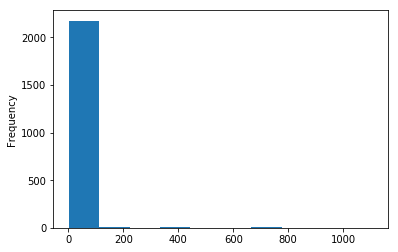

In [20]:
subset.elapsed.plot(kind='hist')

In [21]:
qd1 = subset['elapsed']>(6*31)
subset.loc[qd1,:]

,faculty,from_ISO2,to_ISO2,elapsed,steps,distance,step_distance,speed,travel_code
3861,LTC,CN,CN,371,2,0.000000,0.000000,0.000000,plane
3863,SBS,BE,FR,278,2,1669.072063,834.536032,0.250161,plane
4007,PHILOSCSOC,BE,HU,715,2,2277.042667,1138.521333,0.132695,plane
4335,PHILOSCSOC,BE,DE,734,2,635.308582,317.654291,0.036064,train
4450,SBS,BE,GB,243,3,2981.695124,993.898375,0.511265,plane
4477,SBS,BE,FR,732,2,700.338534,350.169267,0.039864,train
4478,SBS,BE,FR,732,2,700.338534,350.169267,0.039864,train
4566,PHILOSCSOC,BE,ML,1109,2,8772.861437,4386.430719,0.329609,plane
4650,LTC,BE,JP,190,2,18901.613670,9450.806835,4.145091,plane
4663,PHILOSCSOC,BE,FR,367,3,542.452270,180.817423,0.061586,train


In [22]:
qd2 = (subset['speed']>=25)&(subset['travel_code']=='car')
subset.loc[qd2,:]

,faculty,from_ISO2,to_ISO2,elapsed,steps,distance,step_distance,speed,travel_code
3736,PHILOSCSOC,BE,DE,1,2,635.308582,317.654291,26.471191,car
3737,PHILOSCSOC,BE,FR,1,2,837.711419,418.855710,34.904642,car
3976,PHILOSCSOC,BE,DE,1,2,610.953994,305.476997,25.456416,car
4174,PHILOSCSOC,BE,BE,1,3,9786.648283,3262.216094,407.777012,car
4197,PHILOSCSOC,BE,DE,1,2,610.953994,305.476997,25.456416,car
4250,PHILOSCSOC,BE,NL,1,2,608.751812,304.375906,25.364659,car
4488,PHILOSCSOC,BE,FR,1,2,813.108089,406.554044,33.879504,car
5061,PHILOSCSOC,BE,CH,1,2,1017.324673,508.662336,42.388528,car
5068,LTC,BE,FR,3,2,1911.723997,955.861998,26.551722,car
5848,PHILOSCSOC,BE,CL,6,2,25359.449409,12679.724704,176.107288,car


In [23]:
qd3 = (subset['distance']>=1000)&(subset['travel_code']=='car')&(subset['elapsed']<=7)
subset.loc[qd3,:]

,faculty,from_ISO2,to_ISO2,elapsed,steps,distance,step_distance,speed,travel_code
3848,PHILOSCSOC,BE,IT,5,2,1457.710801,728.855401,12.147590,car
4001,PHILOSCSOC,FR,FR,6,2,1325.378541,662.689270,9.204018,car
4002,PHILOSCSOC,FR,FR,6,2,1325.378541,662.689270,9.204018,car
4018,PHILOSCSOC,BE,IT,7,2,1216.990557,608.495279,7.243991,car
4045,PHILOSCSOC,BE,CH,2,2,1017.324673,508.662336,21.194264,car
4171,SBS,BE,CH,5,2,1228.607030,614.303515,10.238392,car
4174,PHILOSCSOC,BE,BE,1,3,9786.648283,3262.216094,407.777012,car
4208,PHILOSCSOC,BE,FR,5,2,1133.146990,566.573495,9.442892,car
4547,SBS,BE,FR,7,2,1142.664452,571.332226,6.801574,car
4765,SBS,BE,FR,4,2,1684.993880,842.496940,17.552020,car


In [24]:
qd4 = subset['speed']>=400
subset.loc[qd4,:]

,faculty,from_ISO2,to_ISO2,elapsed,steps,distance,step_distance,speed,travel_code
3947,SBS,BE,AR,2,2,22536.192132,11268.096066,469.504003,plane
4174,PHILOSCSOC,BE,BE,1,3,9786.648283,3262.216094,407.777012,car
5192,LTC,BE,CN,1,2,15963.512475,7981.756237,665.146353,plane
5195,SBS,BE,AR,2,2,22536.192132,11268.096066,469.504003,plane
5521,SBS,BE,AU,3,2,33591.825055,16795.912528,466.553126,train
5751,SBS,BE,AR,1,2,22536.192132,11268.096066,939.008005,train
5863,LTC,BE,CN,1,2,15963.512475,7981.756237,665.146353,plane


In [25]:
qd = qd1|qd2|qd3|qd4

In [26]:
subset = subset.loc[~qd,:]

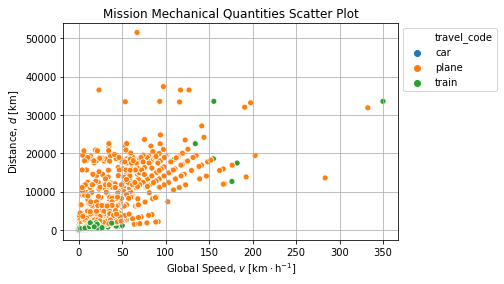

In [27]:
axe = sns.scatterplot(x='speed', y='distance', hue='travel_code', data=subset)
axe.set_title("Mission Mechanical Quantities Scatter Plot")
axe.set_xlabel(r"Global Speed, $v$ $[\mathrm{km\cdot h^{-1}}]$")
axe.set_ylabel(r"Distance, $d$ $[\mathrm{km}]$")
axe.legend(bbox_to_anchor=(1,1), loc='upper left')
axe.grid()

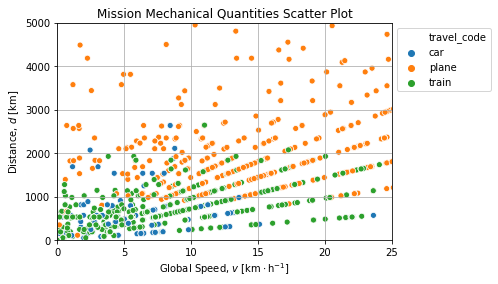

In [28]:
axe = sns.scatterplot(x='speed', y='distance', hue='travel_code', data=subset)
axe.set_title("Mission Mechanical Quantities Scatter Plot")
axe.set_xlabel(r"Global Speed, $v$ $[\mathrm{km\cdot h^{-1}}]$")
axe.set_ylabel(r"Distance, $d$ $[\mathrm{km}]$")
axe.legend(bbox_to_anchor=(1,1), loc='upper left')
axe.set_xlim([0, 25])
axe.set_ylim([0, 5000])
axe.grid()

#### Spliting dataset

In [29]:
tkey = ['distance', 'speed', 'elapsed', 'steps']
X = subset[tkey]

In [30]:
y = subset['travel_code'].cat.codes

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=20)

In [32]:
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

#### K-Nearest-Neighbors Classifier

In [33]:
C = KNeighborsClassifier(n_neighbors=7, p=1, metric='minkowski')
C.fit(X_train, y_train)
score1 = C.score(X_train, y_train)
score2 = C.score(X_test, y_test)
print("Train Score: {}, Test Score: {}".format(score1, score2))

Train Score: 0.8717816683831102, Test Score: 0.8657407407407407


In [34]:
Cx = C

In [35]:
Cstd = KNeighborsClassifier(n_neighbors=7, p=1, metric='minkowski')
Cstd.fit(X_train_std, y_train)
score1 = Cstd.score(X_train_std, y_train)
score2 = Cstd.score(X_test_std, y_test)
print("Train Score: {}, Test Score: {}".format(score1, score2))

Train Score: 0.8480947476828012, Test Score: 0.8611111111111112


#### RadiusNeighborsClassifier

In [36]:
C = RadiusNeighborsClassifier()
Cstd.fit(X_train_std, y_train)
score1 = Cstd.score(X_train_std, y_train)
score2 = Cstd.score(X_test_std, y_test)
print("Train Score: {}, Test Score: {}".format(score1, score2))

Train Score: 0.8480947476828012, Test Score: 0.8611111111111112


#### Decision Tree Classifier

In [37]:
C = tree.DecisionTreeClassifier()
C.fit(X_train, y_train)
score1 = C.score(X_train, y_train)
score2 = C.score(X_test, y_test)
print("Train Score: {}, Test Score: {}".format(score1, score2))

Train Score: 0.9515962924819773, Test Score: 0.8657407407407407


#### Gaussian Naive Bayse

In [38]:
C = GaussianNB()
C.fit(X_train, y_train)
score1 = C.score(X_train, y_train)
score2 = C.score(X_test, y_test)
print("Train Score: {}, Test Score: {}".format(score1, score2))

Train Score: 0.5087538619979403, Test Score: 0.46296296296296297


In [39]:
Cstd = GaussianNB()
Cstd.fit(X_train_std, y_train)
score1 = Cstd.score(X_train_std, y_train)
score2 = Cstd.score(X_test_std, y_test)
print("Train Score: {}, Test Score: {}".format(score1, score2))

Train Score: 0.5005149330587023, Test Score: 0.4398148148148148


In [40]:
Clabel = Cx.predict(missions[tkey])
Clabel

array([2, 2, 2, ..., 1, 2, 1], dtype=int8)

In [41]:
Cprob = Cx.predict_proba(missions[tkey])
Cprob[range(Cprob.shape[0]), Clabel]

array([0.85714286, 1.        , 1.        , ..., 0.57142857, 0.85714286,
       0.85714286])

In [42]:
ctrans = dict(enumerate(missions['travel_code'].cat.categories))

In [43]:
missions['travel_class'] = Clabel
missions['travel_class'] = pd.Categorical(missions['travel_class'].replace(ctrans))
missions['travel_code'] = missions['travel_code'].fillna(missions['travel_class'])
missions['travel_proba'] = Cprob[range(Cprob.shape[0]), Clabel]
missions

,mission_id,acronym,faculty,start,stop,elapsed,travel_type,from_ISO2,to_ISO2,distance,speed,steps,step_distance,ISO2_chain,travel_code,travel_class,travel_proba
0,0,DECA,LTC,2010-05-28,2010-06-01,5,NaN,BE,GB,810.745964,6.756216,3,270.248655,"[BE, GB, GB, BE]",train,train,0.857143
1,1,SIC,LTC,2010-06-22,2010-07-08,17,NaN,BE,GB,645.698894,1.582595,2,322.849447,"[BE, GB, BE]",train,train,1.000000
2,2,SIC,LTC,2010-06-22,2010-07-08,17,NaN,BE,GB,645.698894,1.582595,2,322.849447,"[BE, GB, BE]",train,train,1.000000
3,3,SIC,LTC,2010-07-12,2010-07-17,6,NaN,BE,GB,645.698894,4.484020,2,322.849447,"[BE, GB, BE]",train,train,1.000000
4,4,SIC,LTC,2010-05-31,2010-06-01,2,NaN,BE,FR,528.587028,11.012230,2,264.293514,"[BE, FR, BE]",train,train,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6125,6125,DECS,SBS,2020-02-20,2020-02-20,1,train,BE,GB,645.698894,26.904121,2,322.849447,"[BE, GB, BE]",train,train,1.000000
6126,6126,DECS,SBS,2020-02-23,2020-02-28,6,train,BE,FR,1923.612609,13.358421,4,480.903152,"[BE, FR, FR, FR, BE]",train,train,0.571429
6127,6127,L&L,LTC,2020-02-16,2020-02-18,3,train,BE,FR,1536.399657,21.338884,2,768.199829,"[BE, FR, BE]",train,plane,0.571429
6128,6128,DECS,SBS,2020-03-02,2020-03-03,2,train,NL,FR,860.923418,17.935905,2,430.461709,"[NL, FR, NL]",train,train,0.857143


In [44]:
coef = pd.read_excel("data/carbon.xlsx", sheet_name="Aggregated")
coef

,travel_code,tortuosity_coef,carbon_coef
0,car,1.24,0.170000
1,plane,1.00,0.116391
2,train,1.15,0.031076


In [45]:
final = missions.merge(coef)

In [46]:
final

,mission_id,acronym,faculty,start,stop,elapsed,travel_type,from_ISO2,to_ISO2,distance,speed,steps,step_distance,ISO2_chain,travel_code,travel_class,travel_proba,tortuosity_coef,carbon_coef
0,0,DECA,LTC,2010-05-28,2010-06-01,5,NaN,BE,GB,810.745964,6.756216,3,270.248655,"[BE, GB, GB, BE]",train,train,0.857143,1.15,0.031076
1,1,SIC,LTC,2010-06-22,2010-07-08,17,NaN,BE,GB,645.698894,1.582595,2,322.849447,"[BE, GB, BE]",train,train,1.000000,1.15,0.031076
2,2,SIC,LTC,2010-06-22,2010-07-08,17,NaN,BE,GB,645.698894,1.582595,2,322.849447,"[BE, GB, BE]",train,train,1.000000,1.15,0.031076
3,3,SIC,LTC,2010-07-12,2010-07-17,6,NaN,BE,GB,645.698894,4.484020,2,322.849447,"[BE, GB, BE]",train,train,1.000000,1.15,0.031076
4,4,SIC,LTC,2010-05-31,2010-06-01,2,NaN,BE,FR,528.587028,11.012230,2,264.293514,"[BE, FR, BE]",train,train,1.000000,1.15,0.031076
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6120,6044,DECB,PHILOSCSOC,2020-01-31,2020-02-01,2,car/gas,FR,FR,564.405120,11.758440,2,282.202560,"[FR, FR, FR]",car,car,0.571429,1.24,0.170000
6121,6085,ScSOC,PHILOSCSOC,2020-01-31,2020-01-31,1,car/diesel,BE,FR,528.587028,22.024460,2,264.293514,"[BE, FR, BE]",car,train,0.857143,1.24,0.170000
6122,6087,SIC,LTC,2020-01-03,2020-01-06,4,car/diesel,BE,FR,419.782592,4.372735,2,209.891296,"[BE, FR, BE]",car,car,0.571429,1.24,0.170000
6123,6104,HAA,PHILOSCSOC,2020-02-04,2020-02-07,4,car/gas,BE,FR,366.927463,3.822161,2,183.463732,"[BE, FR, BE]",car,car,0.714286,1.24,0.170000


In [47]:
final['corrected_distance'] = final['distance']*final['tortuosity_coef']
final['CO2_equiv'] = final['corrected_distance']*final['carbon_coef']

In [48]:
final = final.sort_values("mission_id")

In [49]:
final

,mission_id,acronym,faculty,start,stop,elapsed,travel_type,from_ISO2,to_ISO2,distance,...,steps,step_distance,ISO2_chain,travel_code,travel_class,travel_proba,tortuosity_coef,carbon_coef,corrected_distance,CO2_equiv
0,0,DECA,LTC,2010-05-28,2010-06-01,5,NaN,BE,GB,810.745964,...,3,270.248655,"[BE, GB, GB, BE]",train,train,0.857143,1.15,0.031076,932.357858,28.973953
1,1,SIC,LTC,2010-06-22,2010-07-08,17,NaN,BE,GB,645.698894,...,2,322.849447,"[BE, GB, BE]",train,train,1.000000,1.15,0.031076,742.553728,23.075600
2,2,SIC,LTC,2010-06-22,2010-07-08,17,NaN,BE,GB,645.698894,...,2,322.849447,"[BE, GB, BE]",train,train,1.000000,1.15,0.031076,742.553728,23.075600
3,3,SIC,LTC,2010-07-12,2010-07-17,6,NaN,BE,GB,645.698894,...,2,322.849447,"[BE, GB, BE]",train,train,1.000000,1.15,0.031076,742.553728,23.075600
4,4,SIC,LTC,2010-05-31,2010-06-01,2,NaN,BE,FR,528.587028,...,2,264.293514,"[BE, FR, BE]",train,train,1.000000,1.15,0.031076,607.875082,18.890326
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2645,6125,DECS,SBS,2020-02-20,2020-02-20,1,train,BE,GB,645.698894,...,2,322.849447,"[BE, GB, BE]",train,train,1.000000,1.15,0.031076,742.553728,23.075600
2646,6126,DECS,SBS,2020-02-23,2020-02-28,6,train,BE,FR,1923.612609,...,4,480.903152,"[BE, FR, FR, FR, BE]",train,train,0.571429,1.15,0.031076,2212.154500,68.744913
2647,6127,L&L,LTC,2020-02-16,2020-02-18,3,train,BE,FR,1536.399657,...,2,768.199829,"[BE, FR, BE]",train,plane,0.571429,1.15,0.031076,1766.859606,54.906929
2648,6128,DECS,SBS,2020-03-02,2020-03-03,2,train,NL,FR,860.923418,...,2,430.461709,"[NL, FR, NL]",train,train,0.857143,1.15,0.031076,990.061931,30.767165


In [50]:
final.to_excel("data/missions_ai.xlsx", index=False)